1. Setup

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.random_projection import GaussianRandomProjection


2. Data Loading

In [7]:
batch_size = 32

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())

test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

3. Baseline Model

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.fc1 = nn.Linear(576, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



4. Training and Evaluation Utilities

In [1]:
def train(dataloader, model, loss_fn, optimizer, log_interval):
    size = len(dataloader.dataset)
    model.train()
    optimizer.zero_grad()
    accuracies = []
    losses = []
    steps = []
    current_accuracy = 0
    current_loss = 0.0
    current_step = 0


    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % log_interval == 0:
            current_step += 1
            current_loss = loss.item()
            current_accuracy = (pred.argmax(1) == y).type(torch.float).sum().item() / y.size(0)

            accuracies.append(current_accuracy)
            losses.append(current_loss)
            steps.append(current_step)

    return losses, accuracies, steps
            

def evaluate(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct
    
    
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

Subset Selection Utilities

In [ ]:
def grad_per_sample(dataloader, model, loss_fn):

    model.train()

    grads = []

    projector = GaussianRandomProjection(n_components=500)
    temp_grads = []

    
    for idx, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        for i in range(len(y)):
            model.zero_grad()
            loss[i].backward(retain_graph=True)
        
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

            grad_vector = []
            for param in model.parameters():
                if param.grad is not None:
                    grad_vector.append(param.grad.view(-1))
            grad_vector = torch.cat(grad_vector).detach().numpy()

            norm = np.linalg.norm(grad_vector)
            if norm > 0:
                grad_vector = grad_vector / norm

            temp_grads.append(grad_vector)

            if len(temp_grads) >= 100:  # Collect just enough to fit projector
                break

    # Fit the projector on a small sample
    projector.fit(np.vstack(temp_grads))

    

    for idx, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)

        for i in range(len(y)):
            model.zero_grad()

            loss[i].backward(retain_graph=True)

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

            grad_vector = []
            for param in model.parameters():
                if param.grad is not None:
                    grad_vector.append(param.grad.view(-1))
            grad_vector = torch.cat(grad_vector).detach().numpy()
            grad_vector = grad_vector / np.linalg.norm(grad_vector)
            grad_vector = projector.transform(grad_vector.reshape(1, -1)).squeeze(0)
            grads.append(grad_vector)

    grads = np.vstack(grads)
    return grads

def kmeans_clustering(grad_array, num_clusters):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size = 1600)
    kmeans.fit(grad_array)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    return centroids, labels

def subset_selection(grad_array, centroids, labels, subset_size):
    selected_idx = []

    num_to_select = max(1, subset_size // len(centroids))

    for cluster_idx in range(len(centroids)):
        cluster_points = np.where(labels == cluster_idx)[0]

        if len(cluster_points) == 0:
            continue
            
        num_to_select_in_cluster = min(num_to_select, len(cluster_points))
        distances = np.linalg.norm(grad_array[cluster_points] - centroids[cluster_idx], axis=1)
        closest_idx = np.argsort(distances)[:num_to_select_in_cluster]
        selected = cluster_points[closest_idx]

        selected_idx.extend(selected.tolist())

    return selected_idx

Training Loop

6. Evaluation



In [ ]:
lr = 0.01
num_clusters = 10
epochs = 30
subset_update_freq = 5
subset_size  = int(len(train_dataloader.dataset) * 0.1)
N = len(train_dataset)

base_net = NeuralNetwork()
coreset_net = NeuralNetwork()

loss_function = nn.CrossEntropyLoss()
grads_loss_function = nn.CrossEntropyLoss(reduction="none")
base_optimizer = optim.SGD(base_net.parameters(), lr=lr)
coreset_optimizer = optim.SGD(coreset_net.parameters(), lr=lr)

subset_dataloader = train_dataloader
random_subset_dataloader = train_dataloader

base_train_losses = []
base_train_accuracy = []
coreset_train_losses = []
coreset_train_accuracy = []

base_test_losses = []
base_test_accuracies = []
coreset_test_losses = []
coreset_test_accuracies = []


for epoch in range(epochs):
    base_train_loss, base_train_accuracy, base_steps = train(random_subset_dataloader, base_net, loss_function, base_optimizer, log_interval=100)
    coreset_train_loss, coreset_train_accuracy, coreset_steps = train(subset_dataloader, coreset_net, loss_function, coreset_optimizer, log_interval=100)

    base_test_loss, base_test_accuracy = evaluate(test_dataloader, base_net, loss_function)
    coreset_test_loss, coreset_test_accuracy = evaluate(test_dataloader, coreset_net, loss_function)

    base_train_losses.extend(base_train_loss)
    base_train_accuracy.extend(base_train_accuracy)
    coreset_train_losses.extend(coreset_train_loss)
    coreset_train_accuracy.extend(coreset_train_accuracy)


    base_test_losses.append(base_test_loss)
    base_test_accuracies.append(base_test_accuracy)
    coreset_test_losses.append(coreset_test_loss)
    coreset_test_accuracies.append(coreset_test_accuracy)

    if epoch % subset_update_freq == 0:
        random_idx = np.random.choice(N, size=subset_size, replace=False)
        random_subset_dataset = Subset(train_dataset, random_idx)
        random_subset_dataloader = DataLoader(random_subset_dataset, batch_size=batch_size, shuffle=True)

        grad_array = grad_per_sample(subset_dataloader, coreset_net, grads_loss_function)
        print("Any NaNs?", np.isnan(grad_array).any())
        print("Any Infs?", np.isinf(grad_array).any())
        centroids, labels = kmeans_clustering(grad_array, num_clusters)
        subset_idx = subset_selection(grad_array, centroids, labels, subset_size)

        subset_dataset = Subset(train_dataset, subset_idx)
        subset_dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)





Test Error: 
 Accuracy: 89.8%, Avg loss: 0.340623 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.332877 

Any NaNs? False
Any Infs? False
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.199478 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.318373 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.126897 

Test Error: 
 Accuracy: 88.2%, Avg loss: 0.361681 

Test Error: 
 Accuracy: 96.8%, Avg loss: 0.095895 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.269886 

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.080734 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.264692 

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.074394 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.247729 

Any NaNs? False
Any Infs? False
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.063086 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.239384 

Test Error: 
 Accuracy: 98.1%, Avg loss: 0.060726 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.230323 

Test Error: 
 Accuracy: 98.2%, Avg loss: 0.059401 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.214052 



7. Visualization

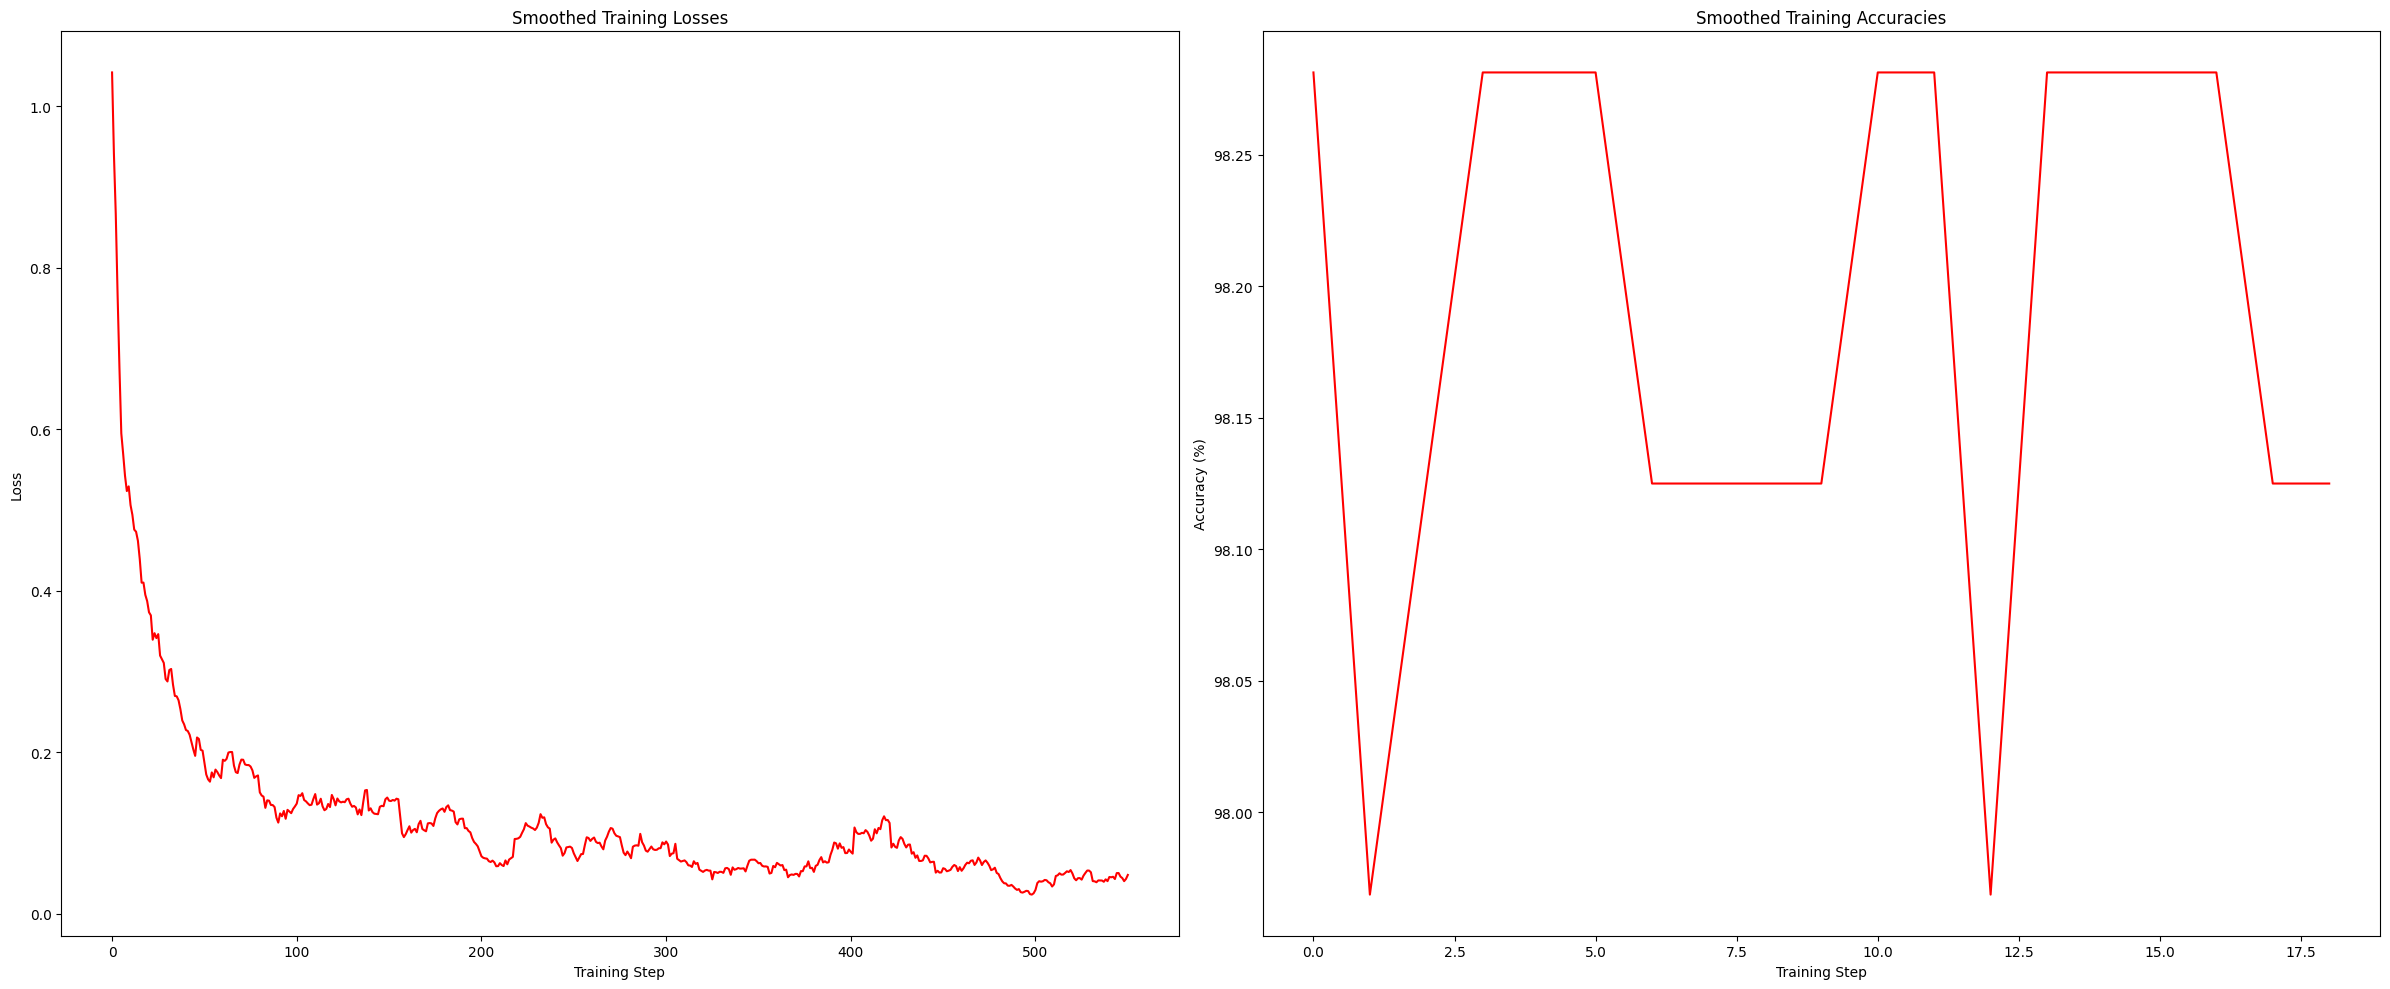

Test Error: 
 Accuracy: 98.9%, Avg loss: 0.038345 



(0.038345418178483415, 0.9885)

In [ ]:



# Smooth the batch-wise losses and accuracies
smoothed_base_losses = moving_average(base_train_losses, window_size=20)
smoothed_base_accuracies = moving_average(base_train_accuracy, window_size=20)
smoothed_coreset_losses = moving_average(coreset_train_losses, window_size=20)
smoothed_coreset_accuracies = moving_average(coreset_train_accuracy, window_size=20)

# Adjust x-axis since moving average shortens the array
adjusted_indices = []

plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)
plt.plot(adjusted_indices, smoothed_base_losses, color="r", label="base")
plt.title('Smoothed Training Losses')
plt.xlabel('Training Step')
plt.ylabel('Loss')

window_adjusted_indices = range(len(train_dataloader.dataset))[:len(smoothed_base_accuracies)]
plt.subplot(1, 2, 2)
plt.plot(window_adjusted_indices, [acc * 100 for acc in smoothed_base_accuracies], color="r", label="base")
plt.title('Smoothed Training Accuracies')
plt.xlabel('Training Step')
plt.ylabel('Accuracy (%)')
'''
plt.subplot(2, 1, 1)
plt.plot(adjusted_indices, smoothed_coreset_losses, color="b", label="coreset")
plt.title('Smoothed Training Losses')
plt.xlabel('Training Step')
plt.ylabel('Loss')

plt.subplot(2, 2, 1)
plt.plot(adjusted_indices, [acc * 100 for acc in smoothed_coreset_accuracies], color="b", label="coreset")
plt.title('Smoothed Training Accuracies')
plt.xlabel('Training Step')
plt.ylabel('Accuracy (%)')'''


plt.tight_layout()
plt.show()

evaluate(test_dataloader, base_net, loss_function)

Conclusion/Next Steps